# Trabajo 1 - Organización de datos - Grupo: Grupby['Banco']

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as geop
import cartopy
import squarify 
from pandas.tseries.offsets import MonthBegin

pd.set_option('display.float_format', '{:.2f}'.format)


In [48]:

# Archivo Zona Prop.
df = pd.read_csv('data/train.csv', index_col=['id'], parse_dates=['fecha'], error_bad_lines=False)

# Archivo Google Trends.
trends = pd.read_csv('data/sentiment_google.csv')
trends['fecha'] = trends.Month.astype(np.datetime64)

# Archivo Inflación de méxico
inflacion_mex = pd.read_csv('./data/inflacion_mex.csv',names=['fecha_mes','indice'],parse_dates=['fecha_mes'],dtype={'indice':np.float64})

# Cambio de base al ultimo dato.
infla2019 = inflacion_mex['indice'].tail(1).values[0]
inflacion_mex['indice'] = (inflacion_mex['indice']/infla2019)*100
# Elimino el número de día para poder joinear ambos DF.
inflacion_mex['fecha_mes'] = inflacion_mex['fecha_mes'].dt.to_period('M')
df['fecha_mes']= df['fecha'].dt.to_period('M')
df = df.merge(inflacion_mex,how='inner',on='fecha_mes')
df['precio_constante'] = (df['precio']/df['indice'])*100


## Consistencia de datos

### NULLS

In [3]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
precio_constante,0,0.00
fecha_mes,0,0.00
precio,0,0.00
centroscomercialescercanos,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
indice,0,0.00
fecha,0,0.00


## Inconsistencia de datos: metros totales y metros cubiertos

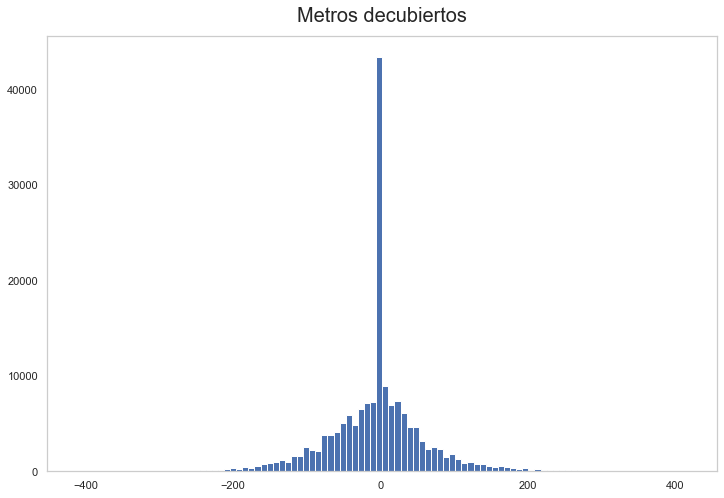

In [63]:
df['metrosdescubiertos'] = df['metrostotales']-df['metroscubiertos']

plt.figure(figsize=(12, 8))
plt.hist(df['metrosdescubiertos'].dropna(), bins=100)
plt.title('Metros decubiertos', fontsize=20, y=1.02)
plt.show()


## Frecuencia y densidad del precio. Distribución asimétrica positiva. (Muchas propiedades baratas)

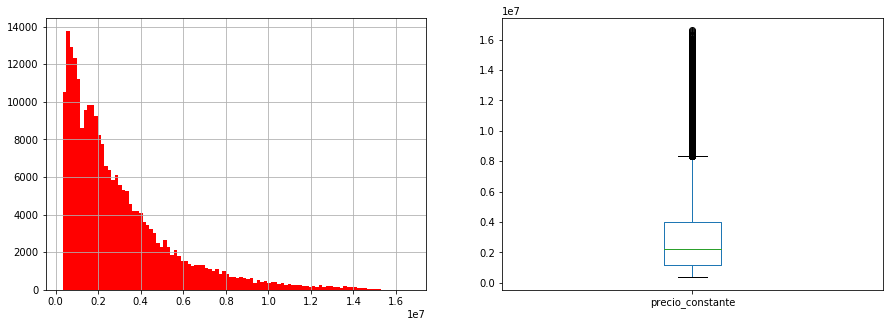

In [5]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
df['precio_constante'].hist(bins=100, ax=axes[0], color='r'); 
df['precio_constante'].plot(kind='box', ax=axes[1]);
plt.show()

## Correlación general entre variables

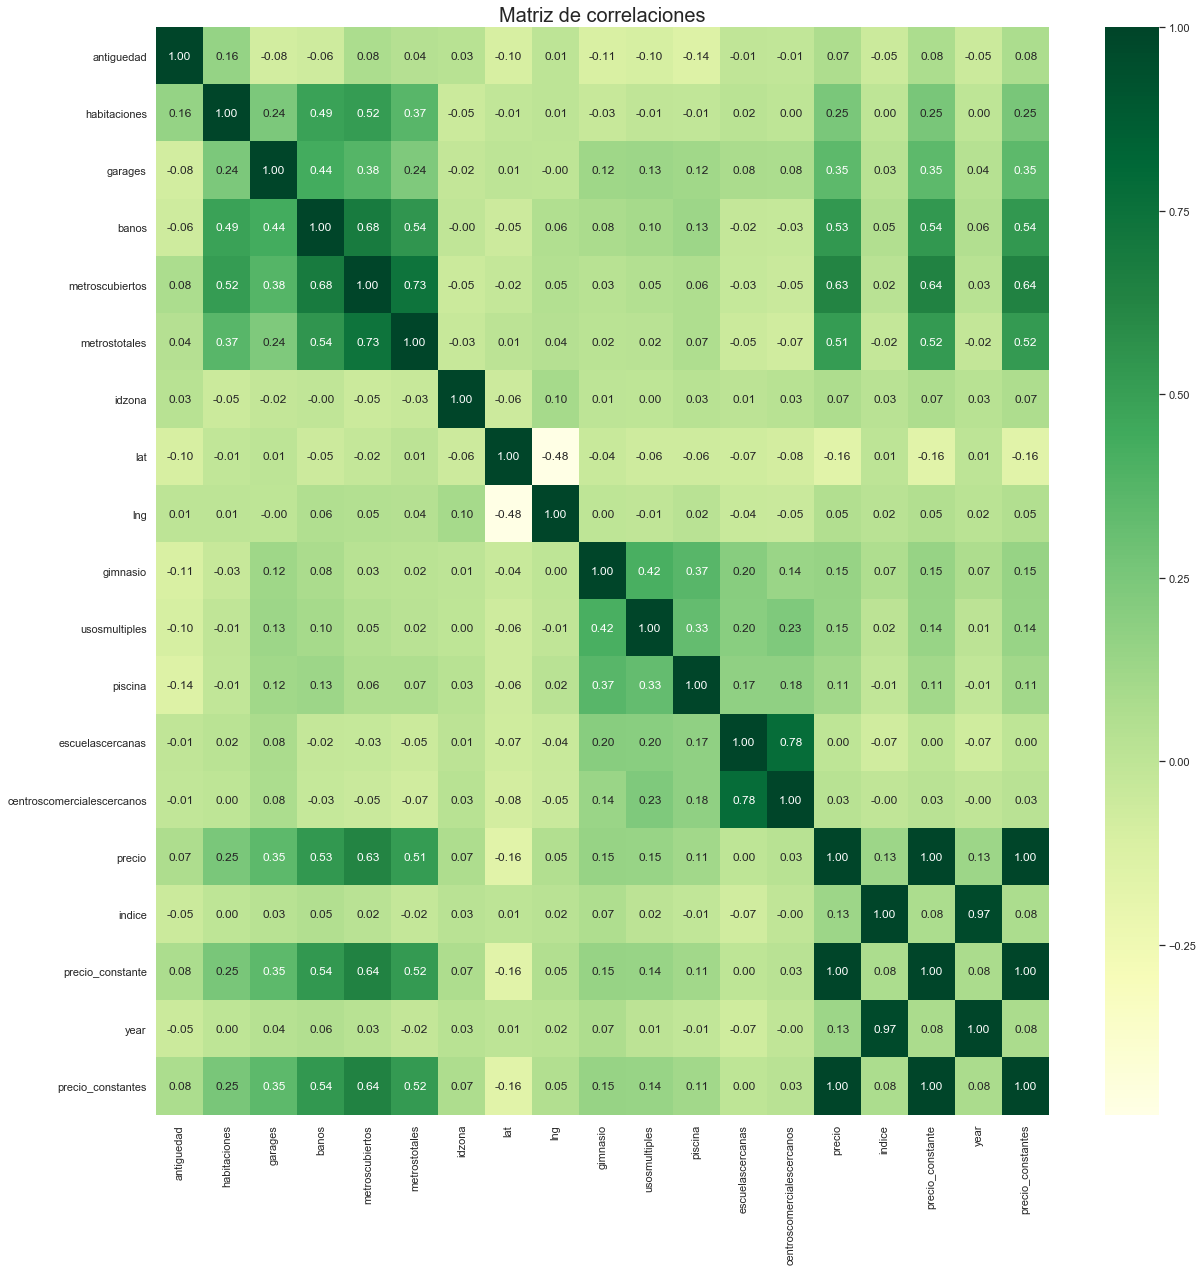

In [57]:
# Creamos una matriz de correlaciones solo para las variables cuantitativas.
#variables_cuantitativas = ['precio', 'metros', 'maxMetros', 'metrostotales','metroscubiertos','banos','garages','habitaciones','antiguedad']
plt.figure(figsize=(20,20))
cm= df.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Matriz de correlaciones', fontsize=20, y=1.02)

plt.show()

## Tipo de propiedades

In [7]:
df['tipodepropiedad'].unique()

array(['Apartamento', 'Casa en condominio', 'Casa', 'Terreno',
       'Local en centro comercial', 'Bodega comercial', 'Edificio',
       'Local Comercial', 'Terreno comercial', 'Otros', 'Villa',
       'Oficina comercial', 'Rancho', 'Casa uso de suelo',
       'Nave industrial', 'Quinta Vacacional', 'Departamento Compartido',
       nan, 'Inmuebles productivos urbanos', 'Huerta', 'Duplex',
       'Terreno industrial', 'Lote', 'Garage', 'Hospedaje'], dtype=object)

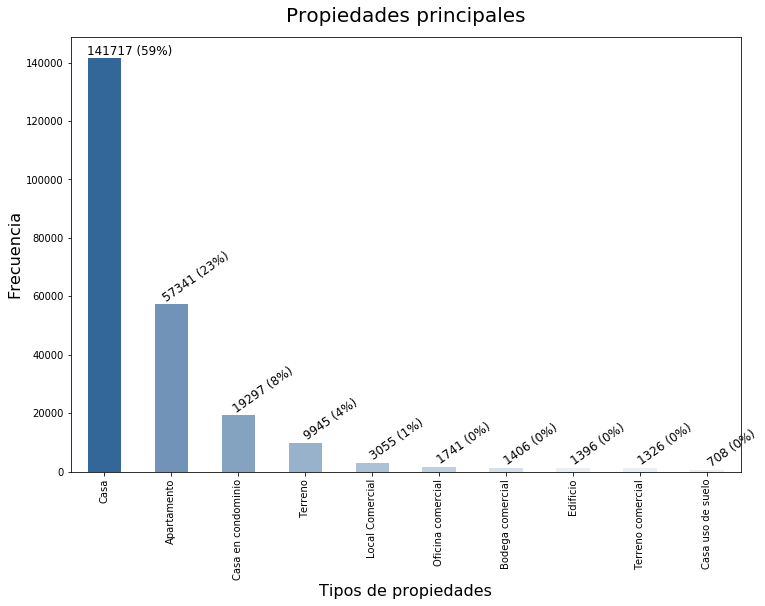

In [8]:
tiposPrincipales = df.tipodepropiedad.value_counts().sort_values(kind="quicksort", ascending=False).to_frame()
tiposPrincipales['porcentaje'] = tiposPrincipales.values / tiposPrincipales.values.sum() * 100
tiposPrincipales = tiposPrincipales.head(10)

plt.figure(figsize=(12, 8))
ax = tiposPrincipales.tipodepropiedad.plot(kind='bar', color=[(0.2, 0.4, 0.6, 1)
                                                            , (0.2, 0.4, 0.6, 0.7)
                                                            , (0.2, 0.4, 0.6, 0.6)
                                                            , (0.2, 0.4, 0.6, 0.5)
                                                            , (0.2, 0.4, 0.6, 0.4)
                                                            , (0.2, 0.4, 0.6, 0.3)
                                                            , (0.2, 0.4, 0.6, 0.2)
                                                            , (0.2, 0.4, 0.6, 0.1)
                                                            , (0.2, 0.4, 0.6, 0.1)
                                                            , (0.2, 0.4, 0.6, 0.1)                                                             
                                                             ])
ax.set_title('Propiedades principales', fontsize=20, y=1.02)
ax.set_xlabel('Tipos de propiedades', fontsize=16)
ax.set_ylabel('Frecuencia', fontsize=16)
ax.set_xticklabels(tiposPrincipales.tipodepropiedad.index)

rects = ax.patches
# Make some labels.
labels = [str(int(row.tipodepropiedad)) + ' (' + str(int(row.porcentaje)) + '%)' for index, row in tiposPrincipales.iterrows()]
angle = 0
i = 0
for rect, label in zip(rects, labels):
    if i != 0:
        angle = 35
    height = rect.get_height()
    ax.text(rect.get_x() + (rect.get_width() * 5 / 4) , height + 5, label,
            ha='center', va='bottom', fontsize=12, rotation=angle)#, rotation_mode='anchor' )
    i += 1

plt.show()
# plt.savefig('tipos-propiedades.png')

<Figure size 864x576 with 0 Axes>

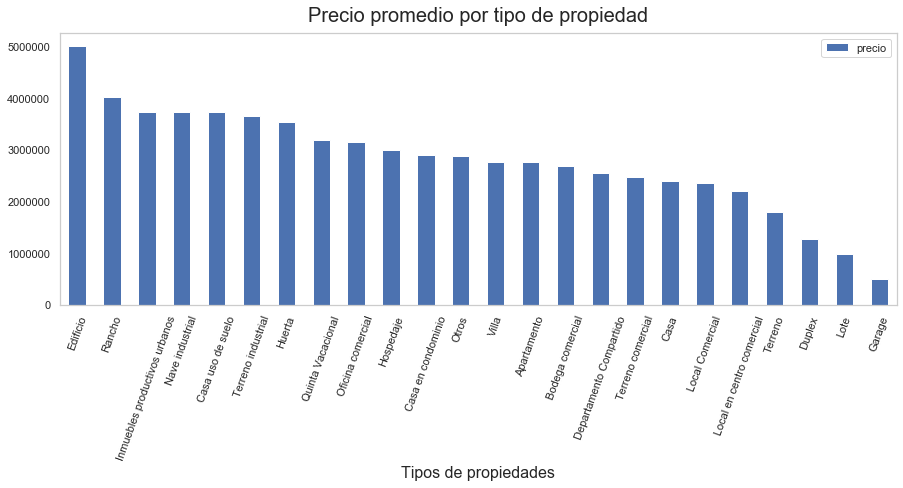

In [64]:
plt.figure(figsize=(12, 8))

ax = df.groupby('tipodepropiedad').agg({'precio': 'mean'})\
       .sort_values('precio', ascending=False)\
       .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por tipo de propiedad");
ax.set_title('Precio promedio por tipo de propiedad', fontsize=20, y=1.02)
ax.set_xlabel('Tipos de propiedades', fontsize=16)
plt.show()

## Regiones

In [10]:
# merge regiones
regiones = pd.read_csv('data/regionesMexico.csv',encoding = "UTF-8")
df = df.merge(regiones,on='provincia', how='inner')

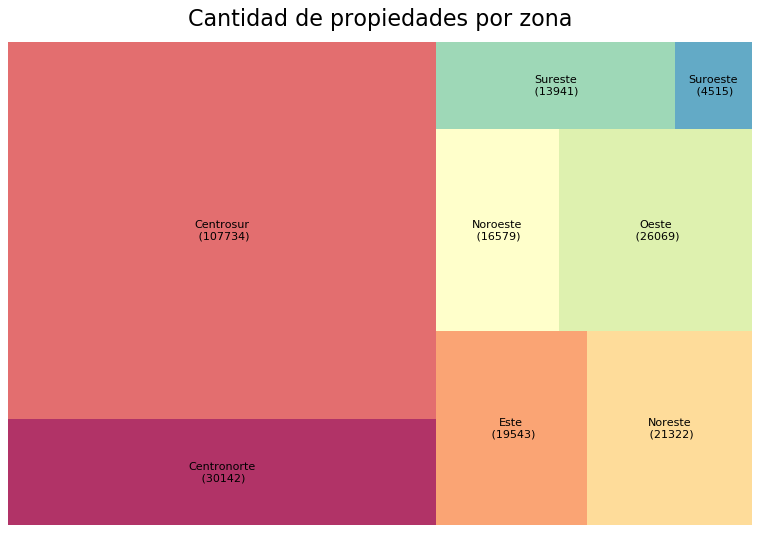

In [13]:
# Prepare Data
df_zonas = df.groupby('zona').size().reset_index(name='counts')
labels = df_zonas.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_zonas['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Cantidad de propiedades por zona', fontsize=20, y=1.02)
plt.axis('off')
plt.show()
# plt.savefig('zonas-cant.png')

## Amenities

In [17]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())

Valores únicos piscina:  [0. 1.]
Valores únicos usos multiples:  [0. 1.]
Valores únicos escuelas cercanas:  [0. 1.]
Valores únicos centros comerciales cercanos:  [0. 1.]


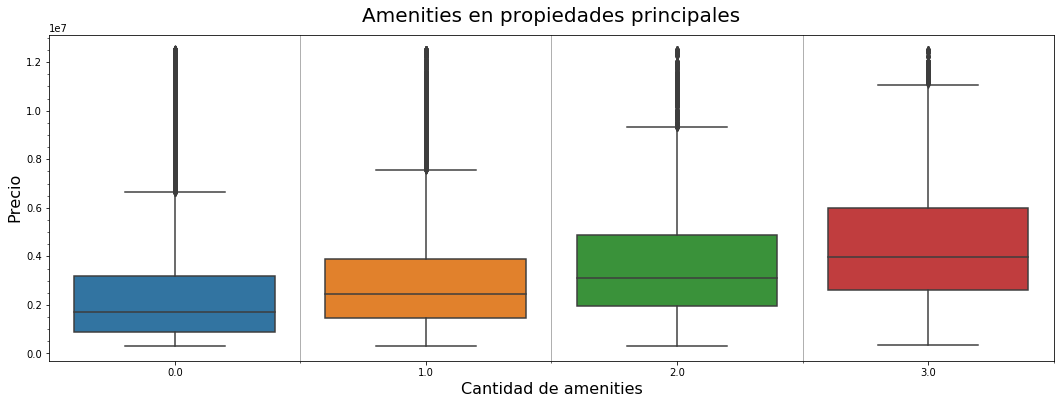

In [18]:
df['amenities'] = df.gimnasio + df.usosmultiples + df.piscina
dfProps = df[df.tipodepropiedad.isin(tiposPrincipales.index)]

from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(18,6))
ax1 = sns.boxplot('amenities', "precio", data=dfProps)

ax1.set_title('Amenities en propiedades principales', fontsize=20, y=1.02)
ax1.set_xlabel('Cantidad de amenities', fontsize=16)
ax1.set_ylabel('Precio', fontsize=16)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

    # plt.savefig('cajas-amenities.png')

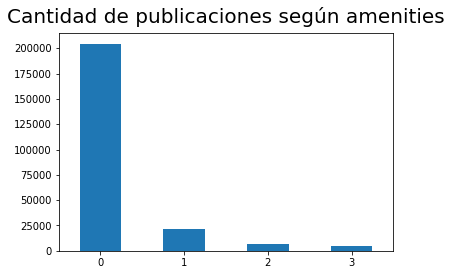

<Figure size 864x576 with 0 Axes>

In [20]:
ax = dfProps.groupby("amenities").amenities.value_counts().plot(kind='bar')
ax.set_title('Cantidad de publicaciones según amenities', fontsize=20, y=1.02)
ax.set_xlabel('', fontsize=16)
labels = [str(int(index[0])) for index, row in dfProps.groupby("amenities").amenities.value_counts().to_frame().iterrows()]
ax.set_xticklabels(labels, rotation=0)


plt.figure(figsize=(12, 8))
rects = ax.patches

plt.show()

## Estacionalidad: mes / día / año

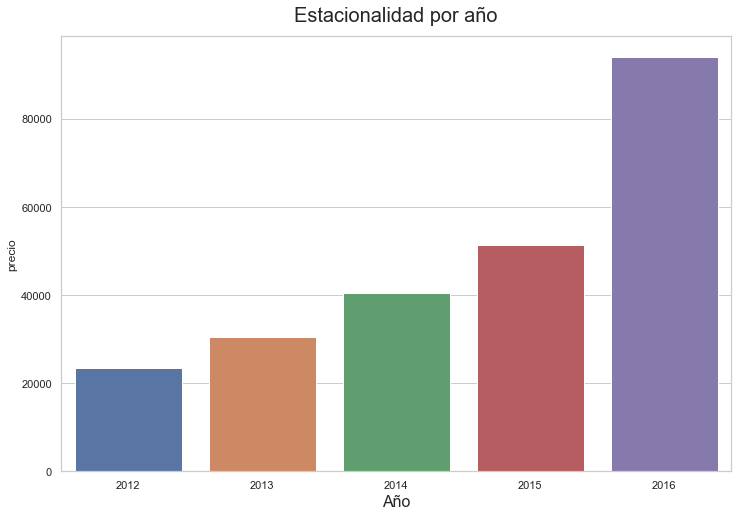

In [67]:
dfViviendas = df
dfViviendas['año'] = dfViviendas.fecha.dt.year

df3 = dfViviendas.groupby(['año'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="año", y="precio", data=df3)
ax.set_title('Estacionalidad por año', fontsize=20, y=1.02)
ax.set_xlabel('Año', fontsize=16)

plt.show()
# plt.ylabel('Cantidad de publicaciones')

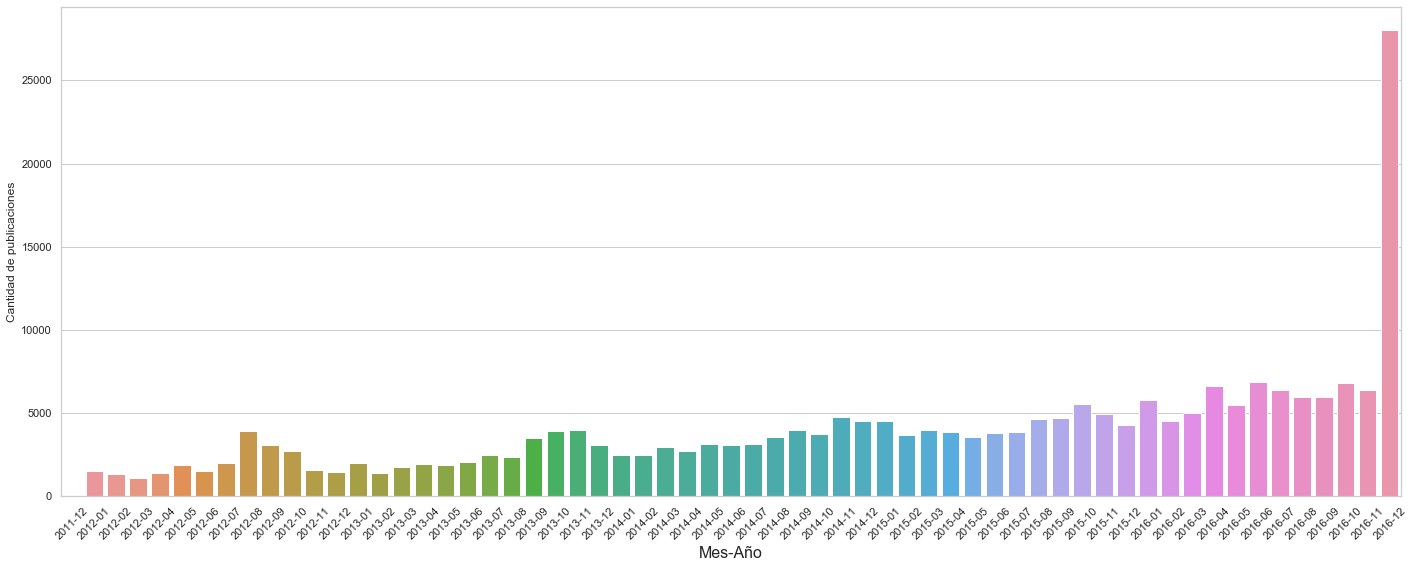

In [69]:
df['mes-año'] = (df.fecha - MonthBegin(1)).dt.strftime('%Y-%m')
df3 = df.groupby(['mes-año'])['precio'].count().to_frame().reset_index()
#df3
plt.figure(figsize=(24,9))
sns.set(style="whitegrid")
ax = sns.barplot(x="mes-año", y="precio", data=df3)
plt.ylabel('Cantidad de publicaciones')
plt.xlabel('Mes-Año', size=16)
plt.xticks(rotation=45)
plt.show()

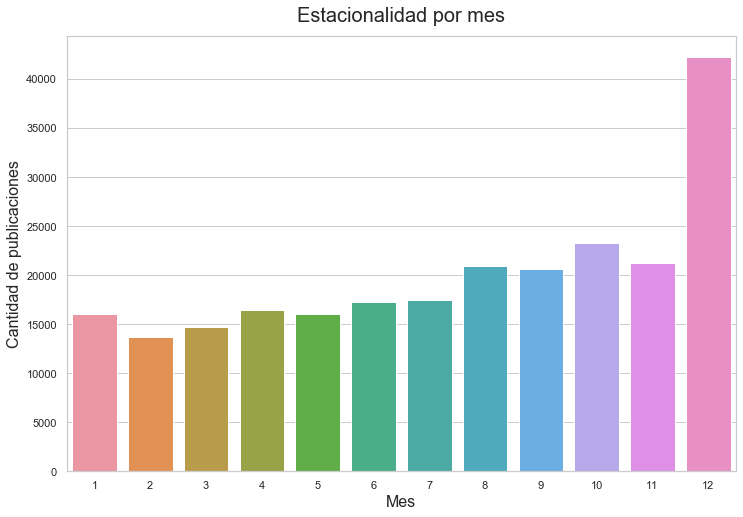

In [71]:
dfViviendas['mes'] = dfViviendas.fecha.dt.month

df3 = dfViviendas.groupby(['mes'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="mes", y="precio", data=df3)
ax.set_title('Estacionalidad por mes', fontsize=20, y=1.02)
ax.set_xlabel('Mes', fontsize=16)
ax.set_ylabel('Cantidad de publicaciones', fontsize=16)

plt.show()

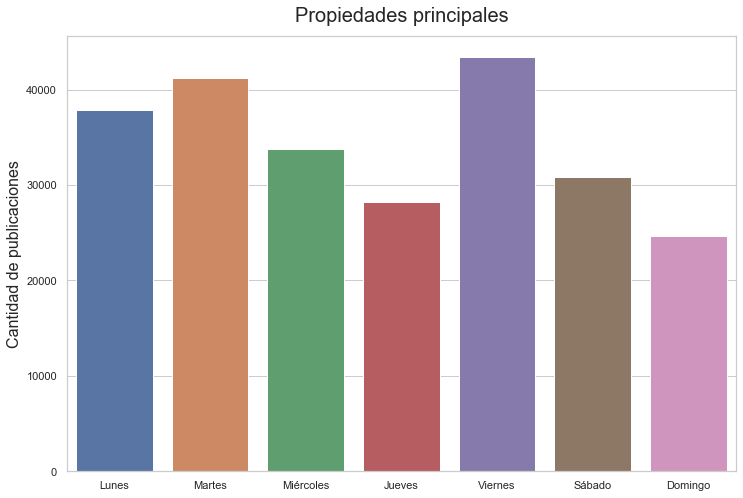

In [74]:
dfViviendas['dia'] = dfViviendas.fecha.dt.dayofweek

df3 = dfViviendas.groupby(['dia'])['precio'].count().to_frame().reset_index()
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="dia", y="precio", data=df3)
ax.set_title('Propiedades principales', fontsize=20, y=1.02)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Cantidad de publicaciones', fontsize=16)
plt.xticks(np.arange(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

## Antiguedad

In [26]:
df.groupby('provincia').agg({'antiguedad':'mean'}).sort_values('antiguedad')

,antiguedad
provincia,
Baja California Sur,2.46
Yucatán,3.07
Hidalgo,3.47
Tlaxcala,3.69
Querétaro,3.70
Campeche,3.91
San luis Potosí,3.98
Quintana Roo,4.54
Puebla,4.55


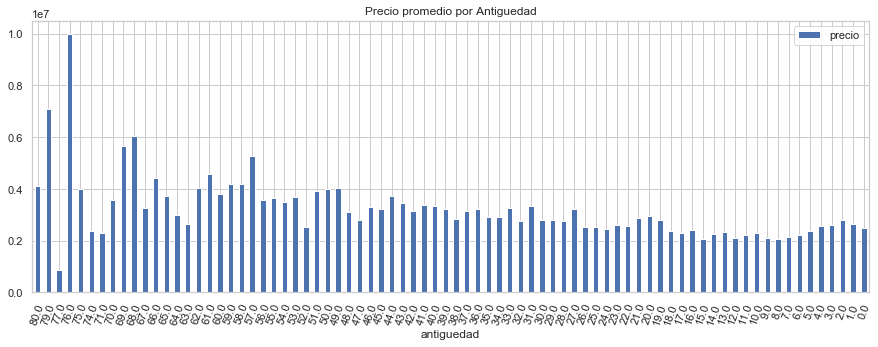

In [27]:
# Precio promedio por tipo de propiedad
df.groupby('antiguedad').agg({'precio': 'mean'})\
    .sort_values('antiguedad', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por Antiguedad");

Text(0, 0.5, '')

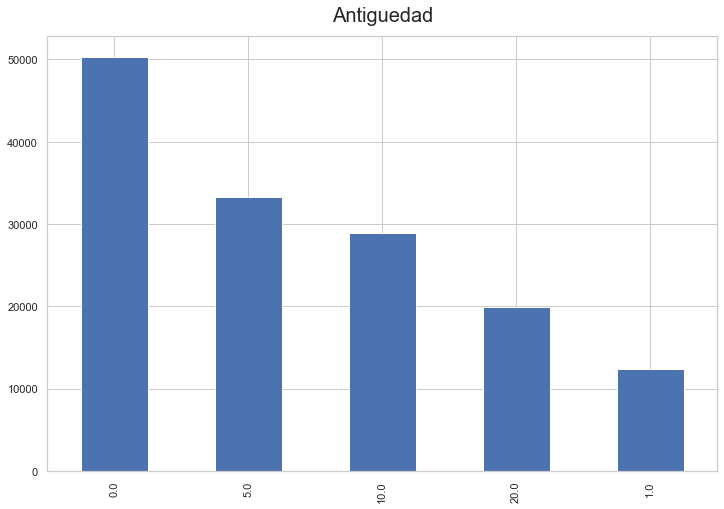

In [78]:
plt.figure(figsize=(12, 8))

ax = df.groupby(by=['antiguedad']).size().sort_values(ascending=False).nlargest(5).plot(kind='bar')

ax.set_title('Antiguedad', fontsize=20, y=1.02)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize=16)


## Análisis de Descripciones

,Content,xAppears
0,empresa dedicada a los ante notario y regist...,119
1,<br>,108
2,"casa, sala comedor, buenas condiciones.",77
3,"casa, sala comedor, patio de servicio, buenas ...",64
4,<br /><br />,59
5,empresa dedicada a los ante notario y regist...,51
6,-- caia --,42
7,valor comercial: \nprecio de venta: \n\n**un...,42
8,"<p>puedes pagarla de contado, infonavit, issst...",40
9,puedes recibir mayor información por whatsapp ...,33


<Figure size 864x576 with 0 Axes>

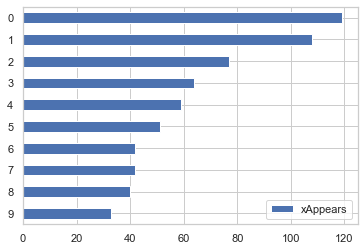

In [75]:
desc_unicas = df['descripcion'].value_counts().to_dict()
desc_df = pd.DataFrame(list(desc_unicas.items()), columns=['Content', 'xAppears'])
desc_df.sort_values(by='xAppears', ascending=True).tail(10).plot(kind='barh')


realtors,0,1
year,,
2012,22947,587
2013,29411,975
2014,39269,1173
2015,49361,2108
2016,89413,4601


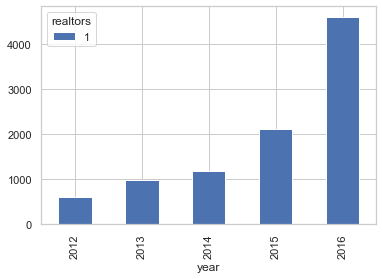

In [40]:
df = df.merge(desc_df,how='left',left_on='descripcion',right_on='Content')
def GetRealtor(x):
    if x > 1:
        return '1'
    else:
        return '0'

df['realtors']= df.xAppears.apply(GetRealtor)
df['year'] = df.fecha.dt.year

df[(df['realtors'] == '1')].groupby(['year'])['realtors'].value_counts().unstack().plot(kind = 'bar')
df.groupby(['year'])['realtors'].value_counts().unstack()

In [41]:
df[df.tipodepropiedad.isin(['Apartamento','Casa','Casa en condominio','Terreno']) & (df.year == 2016)].\
groupby(['provincia','tipodepropiedad','year','realtors'])['precio'].mean().unstack()

realtors                                               0          1
provincia             tipodepropiedad    year                      
Aguascalientes        Apartamento        2016 2518333.33        nan
                      Casa               2016 1681422.00 1357543.33
                      Casa en condominio 2016 1997854.25        nan
                      Terreno            2016 1128288.86  398000.00
Baja California Norte Apartamento        2016  727695.10  591219.40
                      Casa               2016  778730.02 1012725.28
                      Casa en condominio 2016  809014.54  569500.00
                      Terreno            2016  559000.00        nan
Baja California Sur   Apartamento        2016 2002909.09 2335000.00
                      Casa               2016 1513813.67  738125.00
                      Casa en condominio 2016 5110000.00  703760.00
                      Terreno            2016 1020197.50 1443267.00
Campeche              Apartamento        2016 2183750.00        nan
                      Casa               2016 1898982.75 4120000.00
                      Casa en condominio 2016 1339500.00 4120000.00
                      Terreno            2016  751322.22        nan
Chiapas               Apartamento        2016  744166.67  522500.00
                      Casa               2016 2127979.81 1973786.68
                      Casa en condominio 2016 1698000.00        nan
                      Terreno            2016 1287800.82        nan
Chihuahua             Apartamento        2016 2744265.00  798500.00
                      Casa               2016 1871268.15 1398616.53
                      Casa en condominio 2016  851419.20  777313.50
                      Terreno            2016 1079257.77        nan
Coahuila              Apartamento        2016 1662500.00        nan
                      Casa               2016 1734715.89 1809445.25
                      Casa en condominio 2016 1244130.77 2846950.00
                      Terreno            2016 1258186.88        nan
Colima                Apartamento        2016 3075107.31  480000.00
                      Casa               2016 1810739.37  477773.50
...                                                  ...        ...
Sinaloa               Casa               2016 1666551.15 1095569.00
                      Casa en condominio 2016 1896410.55        nan
                      Terreno            2016 1236000.00        nan
Sonora                Apartamento        2016 1948298.30        nan
                      Casa               2016 1674869.33 2361301.15
                      Casa en condominio 2016  633392.50        nan
                      Terreno            2016  941964.71        nan
Tabasco               Apartamento        2016 2741070.47 2861500.00
                      Casa               2016 2766204.50 3690000.00
                      Casa en condominio 2016 4850000.00        nan
                      Terreno            2016 1257790.72        nan
Tamaulipas            Apartamento        2016  902437.94  403750.00
                      Casa               2016 1865414.34 1468004.18
                      Casa en condominio 2016 2094275.27 2390080.00
                      Terreno            2016  943456.86        nan
Tlaxcala              Apartamento        2016  457360.00        nan
                      Casa               2016 1104196.82 1641683.00
                      Casa en condominio 2016  685088.25        nan
                      Terreno            2016 2034938.46        nan
Veracruz              Apartamento        2016 2085877.74 1270862.50
                      Casa               2016 2090056.47 1434083.35
                      Casa en condominio 2016 1307227.79        nan
                      Terreno            2016 1158823.48        nan
Yucatán               Apartamento        2016 2286513.66 1995395.40
                      Casa               2016 2001549.14 1715003.97
                      Casa en condominio 2016 2479871.73

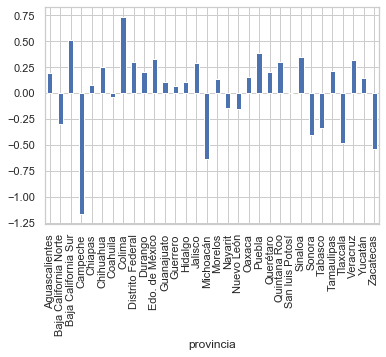

In [44]:
real_casa16 = df[df.tipodepropiedad.isin(['Casa']) & (df.year == 2016)] \
                                   .groupby(['provincia','realtors'])['precio'] \
                                   .mean() \
                                   .unstack()
real_casa16['delta'] = (real_casa16['0'] - real_casa16['1']) / real_casa16['0']
real_casa16['delta'].plot(kind='bar')

## Correlación de Google Trends con caracteristicas de venta

In [51]:
df_trend = df
df_trend['fecha']= pd.to_datetime(df_trend['fecha'], errors='coerce')
df_trend['year']=df_trend.fecha.dt.year
df_trend['precio_constantes'] = (df_trend['precio']/df_trend['indice'])*100
# Preparando datos
sentiment = df_trend.merge(trends,how='inner',on='fecha')
sentiment2 = sentiment[['tipodepropiedad', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'fecha',
       'precio', 'year', 'fecha_mes',
       'precio_constantes', 'Month', 'comprar casa: (Mexico)',
       'vender casa: (Mexico)']]
sentimentCasas = sentiment.loc[(sentiment2.tipodepropiedad=='Casa') & (sentiment2.habitaciones==3)]
sentimentCasas['month'] = sentimentCasas.fecha_mes.dt.month
corrSentimentCasas = sentimentCasas[['antiguedad','garages',\
                                     'metroscubiertos','metrostotales','year','month',\
                                     'precio_constantes','comprar casa: (Mexico)','vender casa: (Mexico)']]

C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


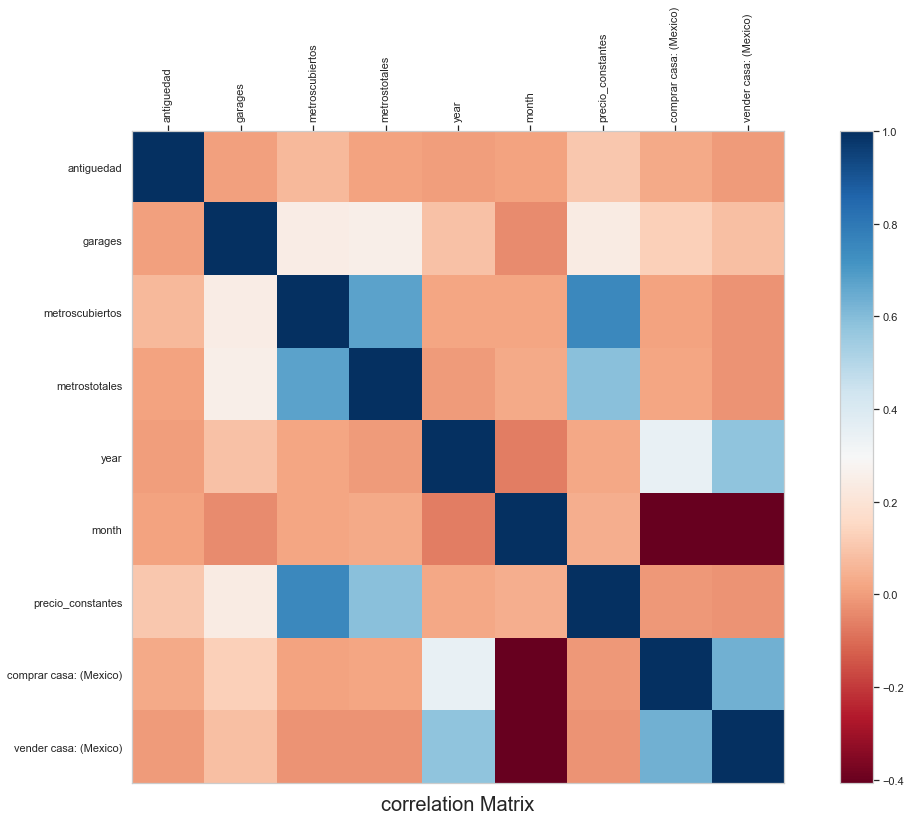

In [52]:
cor = corrSentimentCasas.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'RdBu')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
#plt.savefig('IMG7')
plt.show()

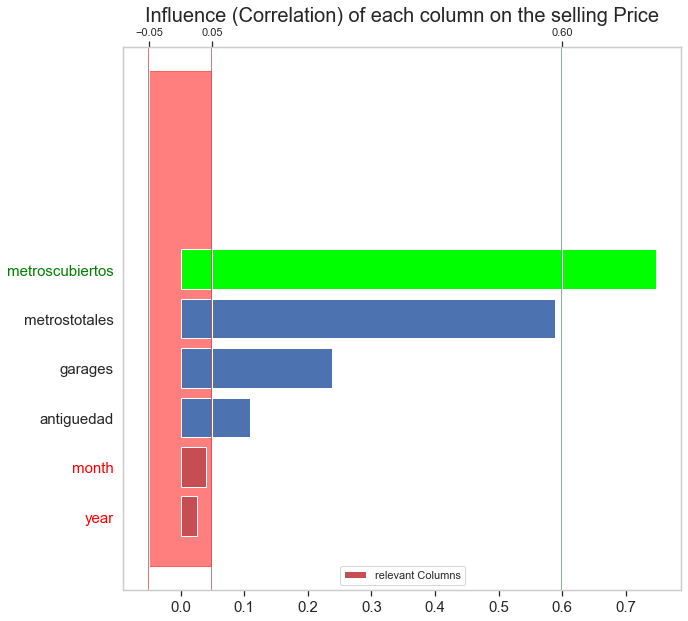

In [53]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.6

corrOrdered = list(upper['precio_constantes'].copy().sort_values())
numNan = upper['precio_constantes'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio_constantes']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the selling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)